## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 
#MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5,0.3]
redice_lr_patient = [5,3]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0728 15:13:41.104317  2112 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0728 15:13:41.106286  2112 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 15:13:41.109278  2112 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0728 15:13:41.211034  2112 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5


W0728 15:13:41.498918  2112 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0728 15:13:41.513840  2112 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0728 15:13:41.612670  2112 deprecation.py:323] From C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
__________

50000/50000 [==============================] - 4s 78us/step - loss: 1.3953 - acc: 0.5101 - val_loss: 1.5496 - val_acc: 0.4524
Epoch 14/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.3775 - acc: 0.5178 - val_loss: 1.5377 - val_acc: 0.4524
Epoch 15/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.3591 - acc: 0.5232 - val_loss: 1.5387 - val_acc: 0.4558
Epoch 16/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.3442 - acc: 0.5296 - val_loss: 1.5264 - val_acc: 0.4606
Epoch 17/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.3281 - acc: 0.5358 - val_loss: 1.5215 - val_acc: 0.4608
Epoch 18/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.3138 - acc: 0.5424 - val_loss: 1.5069 - val_acc: 0.4678
Epoch 19/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.2989 - acc: 0.5471 - val_loss: 1.5064 - val_acc: 0.4673
Epoch 20/25
50000/50000 [=====================

50000/50000 [==============================] - 5s 100us/step - loss: 2.3710 - acc: 0.2341 - val_loss: 2.2795 - val_acc: 0.2930
Epoch 2/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.8716 - acc: 0.3550 - val_loss: 1.9072 - val_acc: 0.3539
Epoch 3/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.7346 - acc: 0.3955 - val_loss: 1.7990 - val_acc: 0.3734
Epoch 4/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.6593 - acc: 0.4210 - val_loss: 1.7277 - val_acc: 0.4021
Epoch 5/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.6027 - acc: 0.4401 - val_loss: 1.6931 - val_acc: 0.4089
Epoch 6/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.5612 - acc: 0.4536 - val_loss: 1.6587 - val_acc: 0.4224
Epoch 7/25
50000/50000 [==============================] - 5s 106us/step - loss: 1.5251 - acc: 0.4646 - val_loss: 1.6361 - val_acc: 0.4286
Epoch 8/25
50000/50000 [==========================

Epoch 23/25
50000/50000 [==============================] - 4s 84us/step - loss: 0.5024 - acc: 0.8528 - val_loss: 1.4769 - val_acc: 0.5236
Epoch 24/25
50000/50000 [==============================] - 4s 87us/step - loss: 0.4893 - acc: 0.8574 - val_loss: 1.4934 - val_acc: 0.5277

Epoch 00024: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 25/25
50000/50000 [==============================] - 4s 86us/step - loss: 0.4650 - acc: 0.8690 - val_loss: 1.4835 - val_acc: 0.5319
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)            

50000/50000 [==============================] - 4s 87us/step - loss: 1.6172 - acc: 0.4372 - val_loss: 1.7218 - val_acc: 0.3968
Epoch 9/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.5971 - acc: 0.4417 - val_loss: 1.7082 - val_acc: 0.4036
Epoch 10/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.5795 - acc: 0.4489 - val_loss: 1.6978 - val_acc: 0.4071
Epoch 11/25
50000/50000 [==============================] - 4s 90us/step - loss: 1.5630 - acc: 0.4545 - val_loss: 1.6865 - val_acc: 0.4116
Epoch 12/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.5473 - acc: 0.4607 - val_loss: 1.6777 - val_acc: 0.4129
Epoch 13/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.5335 - acc: 0.4655 - val_loss: 1.6666 - val_acc: 0.4167
Epoch 14/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.5220 - acc: 0.4675 - val_loss: 1.6628 - val_acc: 0.4174
Epoch 15/25
50000/50000 [======================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.8444 - acc: 0.3662 - val_loss: 2.5436 - val_acc: 0.2098
Epoch 2/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.5439 - acc: 0.4538 - val_loss: 9.2421 - val_acc: 0.1065
Epoch 3/25
50000/50000 [==============================] - 6s 111us/step - loss: 1.4327 - acc: 0.4920 - val_loss: 3.1993 - val_acc: 0.2133
Epoch 4/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.3527 - acc: 0.5200 - val_loss: 1.8681 - val_acc: 0.3582
Epoch 5/25
50000/50000 [==============================] - 5s 105us/step - loss: 1.2881 - acc: 0.5432 - val_loss: 2.0079 - val_acc: 0.3425
Epoch 6/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.2320 - acc: 0.5643 - val_loss: 1.6979 - val_acc: 0.4147
Epoch 7/25
50000/50000 [==============================] - 4s 90us/step - loss: 1.1793 - acc: 0.5841 - val_loss: 1.6885 - val

50000/50000 [==============================] - 4s 87us/step - loss: 0.8786 - acc: 0.7131 - val_loss: 1.3930 - val_acc: 0.5187
Epoch 22/25
50000/50000 [==============================] - 4s 87us/step - loss: 0.8712 - acc: 0.7152 - val_loss: 1.4014 - val_acc: 0.5168
Epoch 23/25
50000/50000 [==============================] - 4s 89us/step - loss: 0.8638 - acc: 0.7191 - val_loss: 1.3936 - val_acc: 0.5206

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 24/25
50000/50000 [==============================] - 4s 88us/step - loss: 0.8513 - acc: 0.7246 - val_loss: 1.3905 - val_acc: 0.5237
Epoch 25/25
50000/50000 [==============================] - 4s 88us/step - loss: 0.8468 - acc: 0.7254 - val_loss: 1.3964 - val_acc: 0.5228
Numbers of exp: 10, reduce_factor: 0.30, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)        

50000/50000 [==============================] - 5s 98us/step - loss: 1.6771 - acc: 0.4166 - val_loss: 1.7658 - val_acc: 0.3918
Epoch 9/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.6449 - acc: 0.4268 - val_loss: 1.7299 - val_acc: 0.4038
Epoch 10/25
50000/50000 [==============================] - 5s 102us/step - loss: 1.6167 - acc: 0.4365 - val_loss: 1.7060 - val_acc: 0.4096
Epoch 11/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.5914 - acc: 0.4452 - val_loss: 1.6849 - val_acc: 0.4122
Epoch 12/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.5682 - acc: 0.4536 - val_loss: 1.6751 - val_acc: 0.4178
Epoch 13/25
50000/50000 [==============================] - 5s 90us/step - loss: 1.5465 - acc: 0.4609 - val_loss: 1.6555 - val_acc: 0.4213
Epoch 14/25
50000/50000 [==============================] - 5s 97us/step - loss: 1.5272 - acc: 0.4676 - val_loss: 1.6401 - val_acc: 0.4274
Epoch 15/25
50000/50000 [=====================

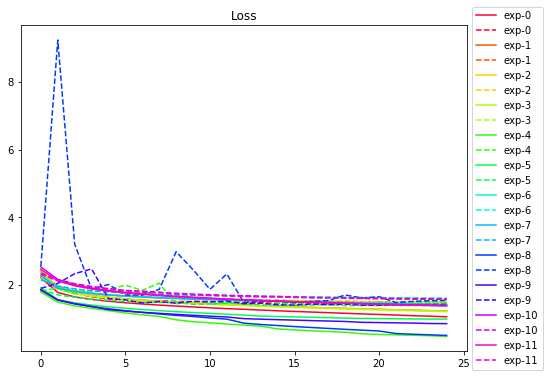

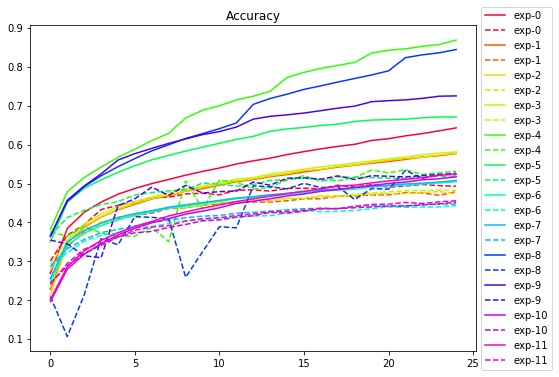

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()